# AIPI 590 - XAI | Assignment #8
### XAI in LLMs
### Ritu Toshniwal

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ritu1412/XAI_LLM/blob/main/notebooks/embedding_visualisation.ipynb)

In [ ]:
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "SHAP-Interpretability"
git_path = 'https://github.com/ritu1412/XAI_LLM.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'notebooks'
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "{path_to_notebook}"
%ls

In [24]:
from datasets import load_dataset
import pandas as pd
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")

# Dataset Loading
Dataset used: http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html

Thought it would be interesting to see the embeddings visualisation of these news articles compareto its true classification.Ideally I would want to see a clear cluster.

In [4]:
# Load and preprocess the dataset
dataset = load_dataset('ag_news', split='train')

In [7]:
#making dataset a dataframe
df = pd.DataFrame(dataset)
df.head()

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [8]:
#distribution of labels
df['label'].value_counts()

label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64

Since the dataset was too large, it made sense to just take few articles from each category for experimentation purposes

In [9]:
#Taking 10 from each category
df = df.groupby('label').head(10).reset_index(drop=True)
df['label'].value_counts()

label
2    10
3    10
1    10
0    10
Name: count, dtype: int64

# Generating embeddings
Embedding model used from the MTEB dashboard: https://huggingface.co/sentence-transformers/sentence-t5-large

In [13]:
model = SentenceTransformer('sentence-transformers/sentence-t5-large')
embeddings = model.encode(df['text'], show_progress_bar=True)

Batches: 100%|██████████| 2/2 [00:03<00:00,  1.75s/it]


# Dimension reduction with PCA, t-SNE and UMAP

In [14]:
# Dimensionality reduction using PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

In [22]:
# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

In [23]:
# Dimensionality reduction using UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(embeddings)

# Plotting the embeddings

In [25]:
# Map labels to colors
unique_labels = df['label'].unique()
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

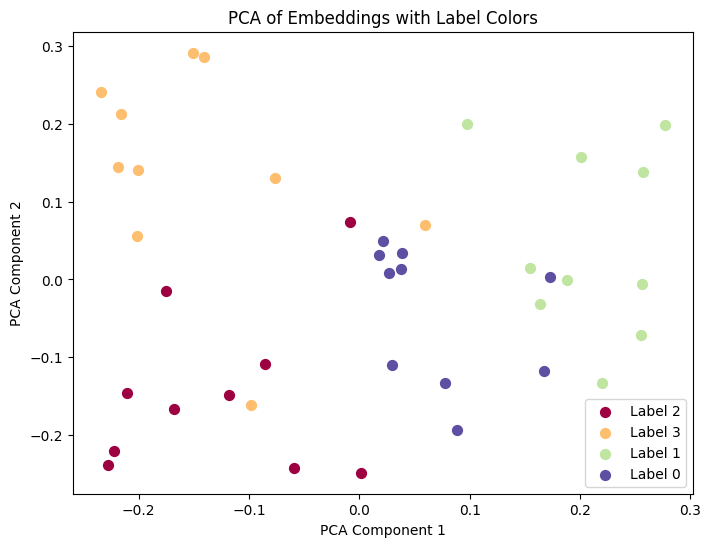

In [26]:
plt.figure(figsize=(8, 6))
for label in unique_labels:
    indices = df['label'] == label
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], c=[color_map[label]], label=f'Label {label}', s=50)

plt.title("PCA of Embeddings with Label Colors")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

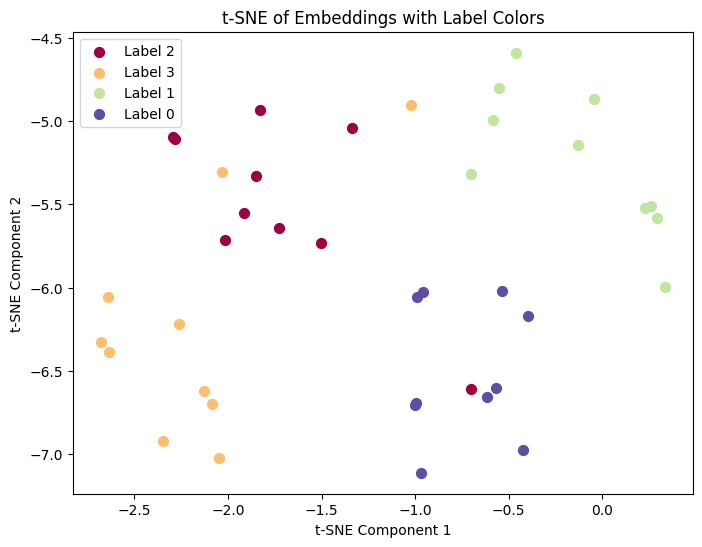

In [28]:
# Plotting t-SNE results
plt.figure(figsize=(8, 6))
for label in unique_labels:
    indices = df['label'] == label
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], c=[color_map[label]], label=f'Label {label}', s=50)
plt.title("t-SNE of Embeddings with Label Colors")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.show()

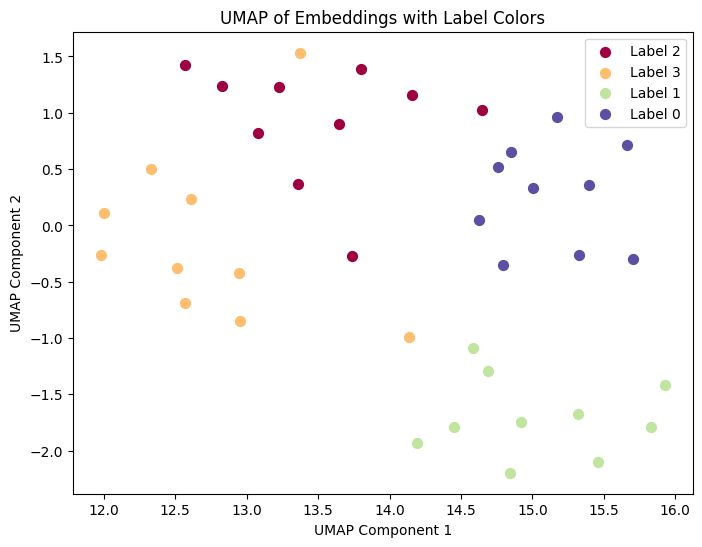

In [30]:
# Plotting UMAP results
plt.figure(figsize=(8, 6))
for label in unique_labels:
    indices = df['label'] == label
    plt.scatter(umap_result[indices, 0], umap_result[indices, 1], c=[color_map[label]], label=f'Label {label}', s=50)
plt.title("UMAP of Embeddings with Label Colors")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.legend()
plt.show()

# Extra
Trying out the visualisation embedding tool from tensorflow

In [32]:
#save results of embeddings with labels in a new dataframe
pca_df = pd.DataFrame(pca_result, columns=['pca1', 'pca2'])

tsne_df = pd.DataFrame(tsne_result, columns=['tsne1', 'tsne2'])

umap_df = pd.DataFrame(umap_result, columns=['umap1', 'umap2'])

#save the results in a tsv file
pca_df.to_csv('embeddings/pca.tsv', sep='\t', index=False)
tsne_df.to_csv('embeddings/tsne.tsv', sep='\t', index=False)
umap_df.to_csv('embeddings/umap.tsv', sep='\t', index=False)

In [33]:
#convert df to tsv
df.to_csv('data/meta_data.tsv', sep='\t', index=False)

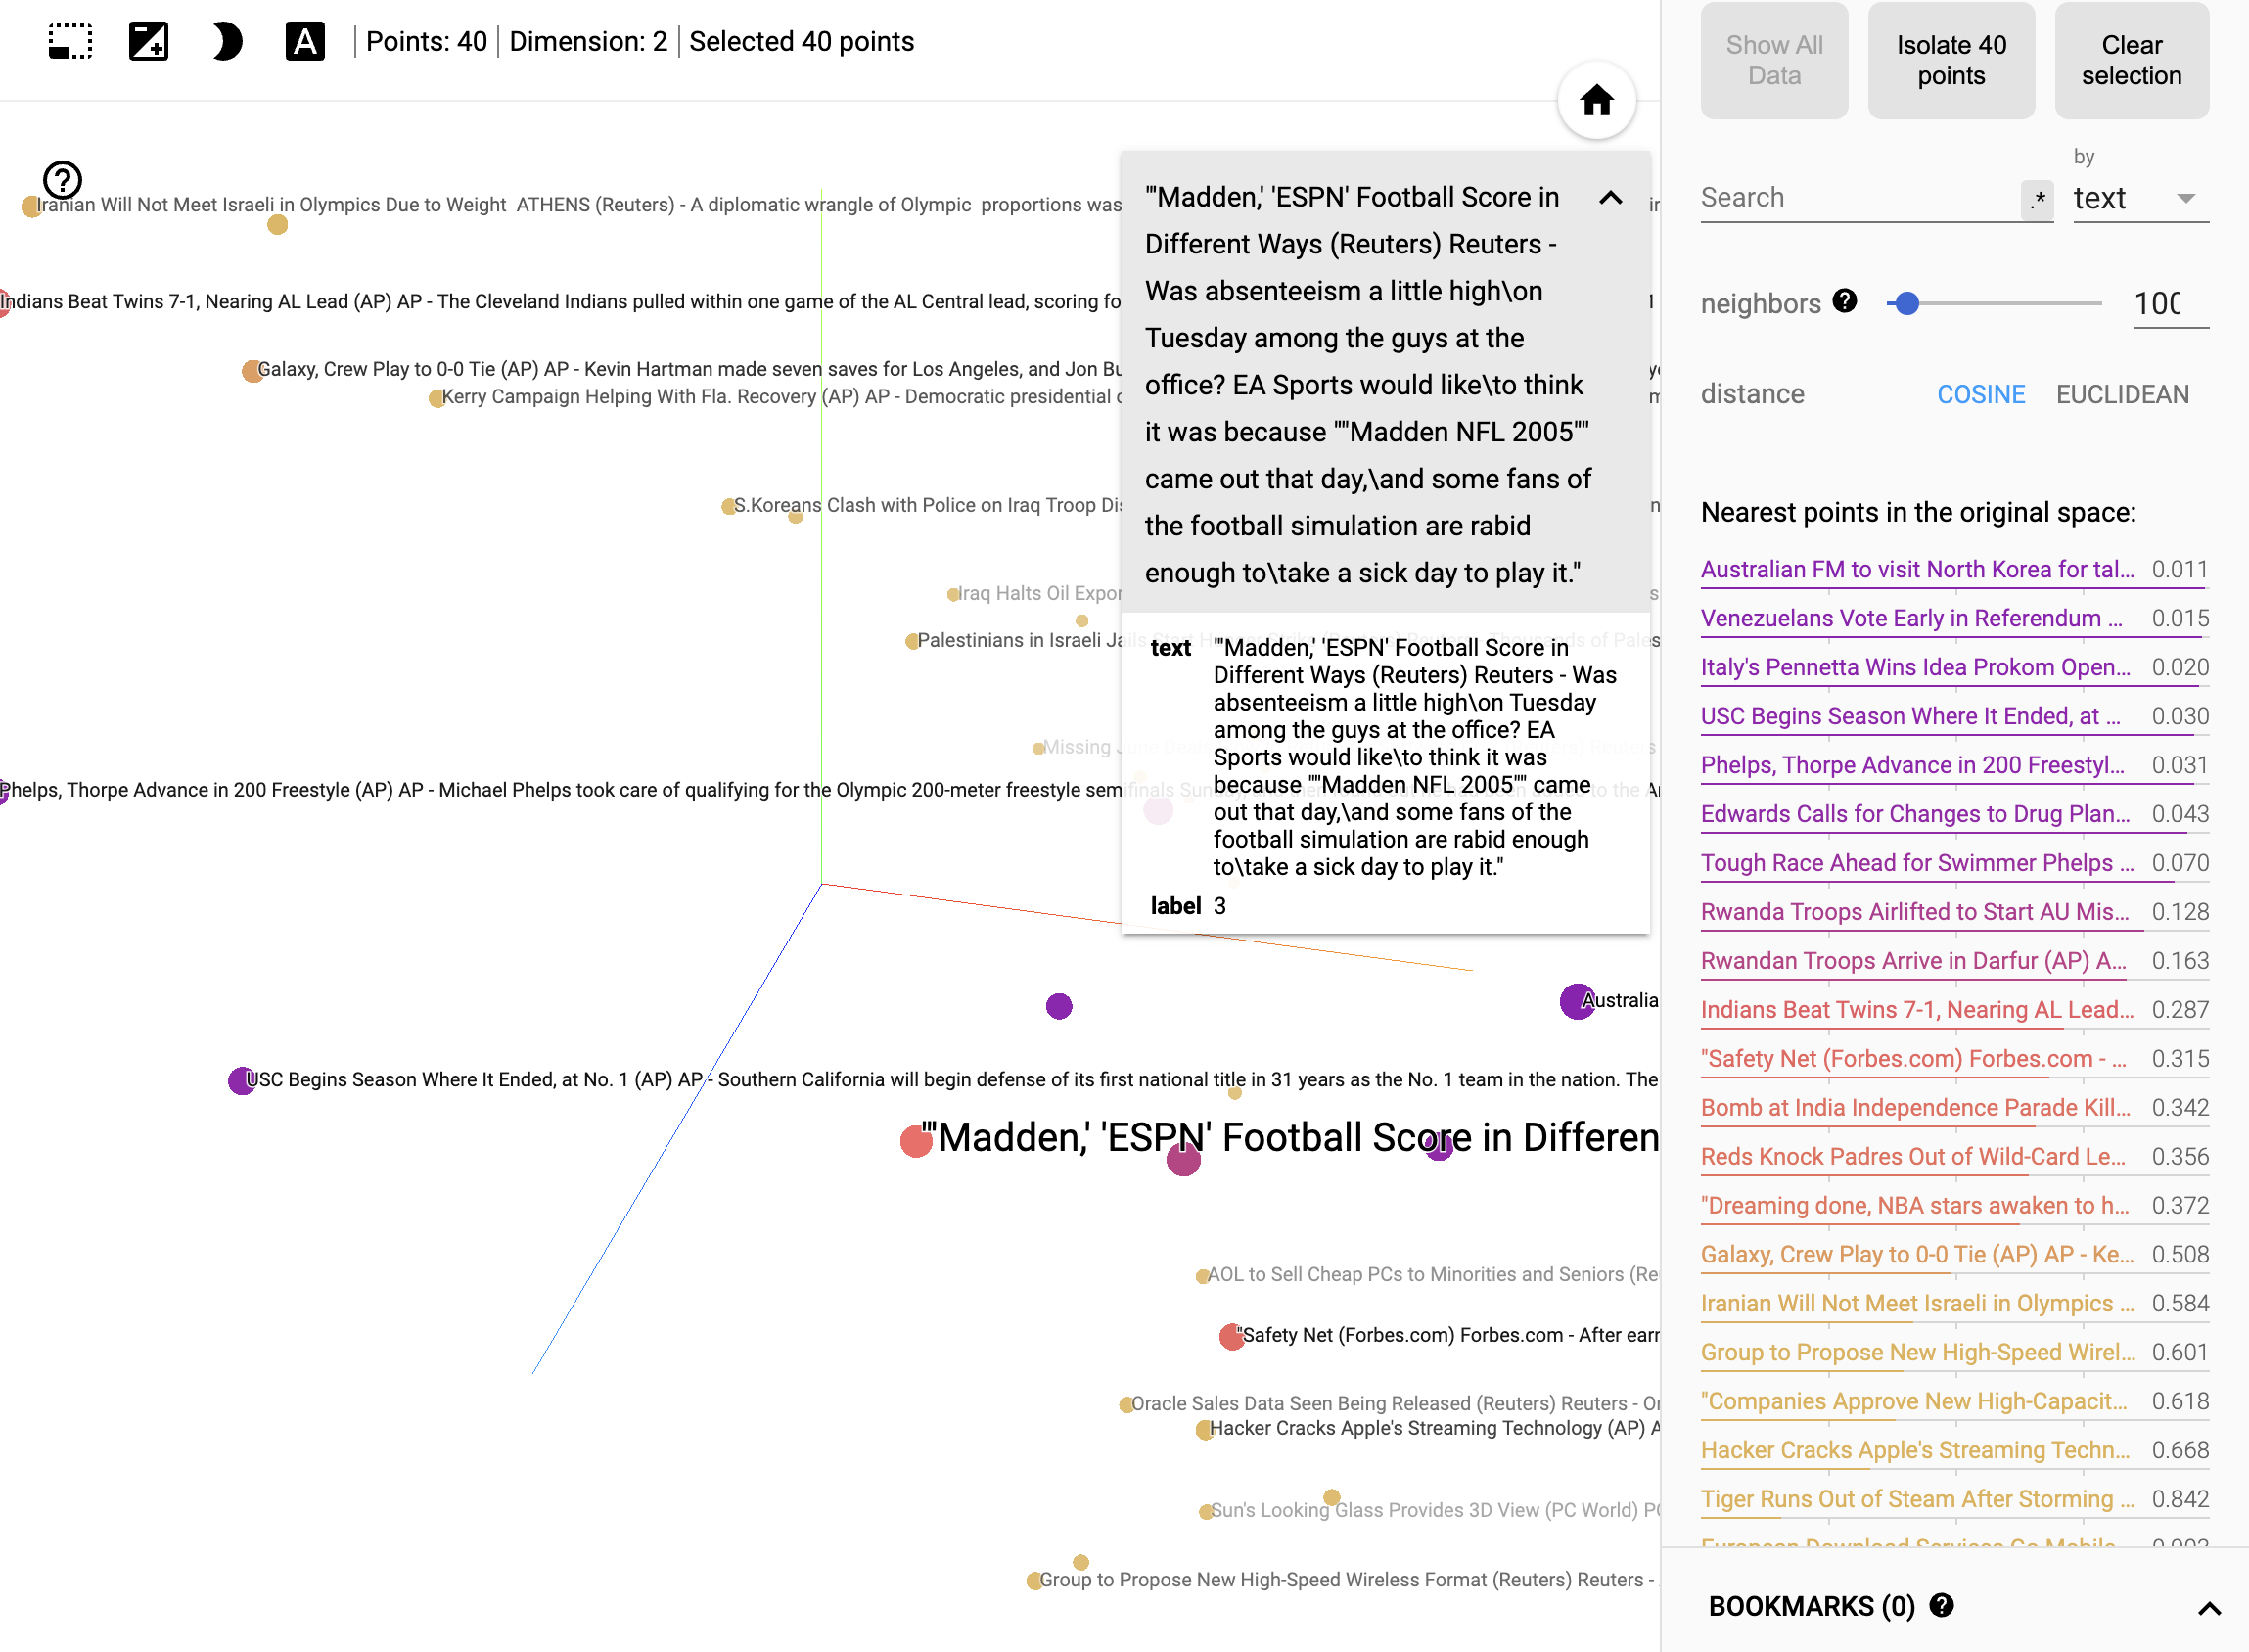

Well for some reason, I didn't get a clear picture here so my analysis will be based on the plots that I had created in 2D space

### PCA (Principal Component Analysis)
In the PCA plot, the clusters are somewhat discernible, but the separation between labels is not as clear as in the other plots. PCA is a linear technique that aims to maximize variance, which means it often captures the global structure well but might struggle with fine-grained, non-linear relationships. Here, the points appear more spread out across the space, and some clusters (especially Label 0 and Label 1) are not clearly separated. This suggests that PCA captures some overall variance but misses the compact clustering observed in t-SNE and UMAP.

### t-SNE (t-Distributed Stochastic Neighbor Embedding)
The t-SNE plot shows clear and distinct clusters, with each label forming well-defined groups. This method is excellent for capturing local relationships, which explains why each label’s points are grouped closely together. However, t-SNE is known to distort global structures, and we see that the distance between clusters does not necessarily imply meaningful relationships (i.e., Label 2 is close to Label 3, but this doesn’t indicate similarity). t-SNE is effective for visualizing separations between clusters, but it doesn’t capture overall structural relationships well.

### UMAP (Uniform Manifold Approximation and Projection)
UMAP provides a balance between capturing local and global structures. In the UMAP plot, clusters for each label are distinct, much like in the t-SNE plot, but there is also a noticeable gradient in how the clusters are arranged in the space. UMAP often does well with complex, high-dimensional data, as it tries to maintain both local and some global structure. This is visible in the plot, where clusters are clearly defined, and there is a slight spatial relationship between clusters, suggesting UMAP is preserving more of the original data structure compared to t-SNE.

### My views
- **PCA** is best for capturing global variance but does not separate clusters as clearly. It’s useful for an initial overview but may miss nuanced relationships in the data.
- **t-SNE** provides excellent cluster separation, highlighting local relationships well. However, it can distort the overall structure and may imply proximity where none exists.
- **UMAP** balances both local and global structures, providing clear clusters with some meaningful inter-cluster arrangement. It captures more of the underlying data structure compared to t-SNE, making it suitable for preserving relationships across clusters.

Overall, if the goal is purely to observe clusters, **t-SNE** is effective. If we want to capture both cluster separation and some overall structure, **UMAP** offers a more informative representation. **PCA** is less effective for clustering but can give a broader, variance-based view of the data distribution.